<a href="https://colab.research.google.com/github/schukinam/otus_dl/blob/master/lesson9_denoising_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist, mnist_transform
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

train_loader, test_loader = mnist(batch_size=200, valid=0, transform=mnist_transform)

In [0]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

In [0]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

#### 0. Обучить многослойный автокодировщик:

In [0]:
models = {'2': Net(2), '32': Net(32)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [0]:
def train_no_noise(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 150 == 0:
            line = 'Train Epoch: {} [{:05d}/{}] '.format(
                epoch, batch_idx * len(data), train_size)
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{:05d}/{}] '.format(
            epoch, batch_idx * len(data), train_size)
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append(models[k]._loss)
        print(line + losses)

In [0]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
line = lambda i, l: '{}: '.format(i) + avg_lambda(l)
    
def test_no_noise(models, loader, log=None):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        if log is not None:
            log[k].append(test_loss[k])
    
    lines = '\n'.join([line(k, test_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [0]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train_no_noise(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test_no_noise(models, test_loader, test_log)

Train Epoch: 1 [00000/60000] 2: 1.140609 32: 1.023298
Train Epoch: 1 [30000/60000] 2: 1.066376 32: 0.669321
Train Epoch: 1 [60000/60000] 2: 1.043830 32: 0.395954
Test set:
2: loss: 1.0415
32: loss: 0.4043

Train Epoch: 2 [00000/60000] 2: 1.041378 32: 0.407727
Train Epoch: 2 [30000/60000] 2: 1.012745 32: 0.313350
Train Epoch: 2 [60000/60000] 2: 0.980298 32: 0.287083
Test set:
2: loss: 0.9813
32: loss: 0.2935

Train Epoch: 3 [00000/60000] 2: 0.982463 32: 0.288931
Train Epoch: 3 [30000/60000] 2: 0.947734 32: 0.289337
Train Epoch: 3 [60000/60000] 2: 0.906951 32: 0.265975
Test set:
2: loss: 0.9077
32: loss: 0.2720

Train Epoch: 4 [00000/60000] 2: 0.906107 32: 0.269371
Train Epoch: 4 [30000/60000] 2: 0.866315 32: 0.264694
Train Epoch: 4 [60000/60000] 2: 0.824044 32: 0.261923
Test set:
2: loss: 0.8211
32: loss: 0.2552

Train Epoch: 5 [00000/60000] 2: 0.822931 32: 0.257690
Train Epoch: 5 [30000/60000] 2: 0.776066 32: 0.242796
Train Epoch: 5 [60000/60000] 2: 0.733964 32: 0.241213
Test set:
2: l

In [0]:
# достаём активации скрытого слоя каждой из моделей
# будем использовать весь тестовый датасет
_, all_test_loader = mnist(batch_size=10000, valid=0, transform=mnist_transform)
all_test_data, all_test_target = next(iter(all_test_loader))
encoder_output_2 = models['2'].E(all_test_data.view(-1, 28*28)).data.numpy()
encoder_output_32 = models['32'].E(all_test_data.view(-1, 28*28)).data.numpy()

In [0]:
def plt_scatters(x, y, name):
    fig, ax = plt.subplots(figsize=(12,8))
    for t in np.unique(y):
        idx = np.where(y == t)
        ax.scatter(x[idx,0], x[idx,1], label=str(t), s=21.)
    ax.set_xlim(np.min(x[:,0])*.999, np.max(x[:,0])*1.001)
    ax.set_ylim(np.min(x[:,1])*.999, np.max(x[:,1])*1.001)
    ax.legend()
    ax.set_title(name)
    plt.show()

##### 0.а. отрисовать классы в латентном представлении автокодировщика с двумерным латентным слоем

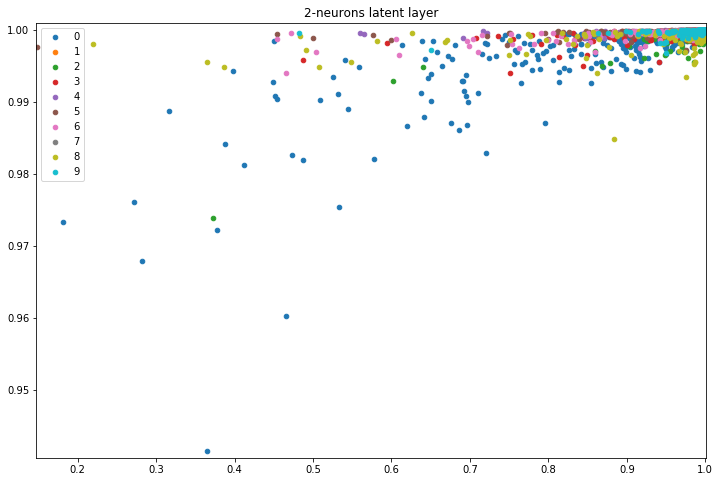

In [0]:
plt_scatters(encoder_output_2, all_test_target, '2-neurons latent layer')

##### 0.б. сделать tSNE над 32-мерным латентным слоем

In [0]:
tsne_model = TSNE(perplexity=10, n_components=2, init='pca', n_iter=10000, verbose=1, metric='cosine')

In [0]:
encoder_output_32_2d = tsne_model.fit_transform(encoder_output_32)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 1.710s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.081771
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.913620
[t-SNE] KL divergence after 10000 iterations: 1.580675


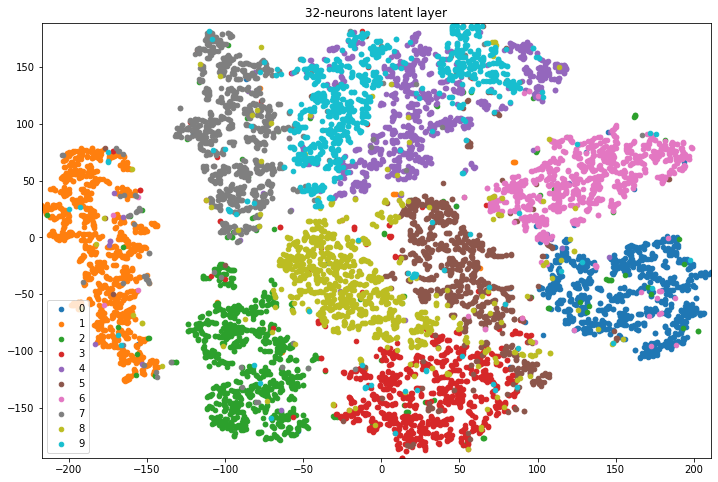

In [0]:
plt_scatters(encoder_output_32_2d, all_test_target, '32-neurons latent layer')

#### 1. Обучить шумный автокодировщик

In [0]:
def add_noise(x, mode='crop', elementwise=True):
    #if np.random.randint(2):
    #    return x
    x = x.clone()
    if elementwise:
        if mode == 'crop':
            for i in range(x.shape[0]):
                img_part = np.random.randint(5)
                zero_one = np.random.randint(2)*2 - 1
                if img_part == 0:
                    x[i, :, :14, :14] = zero_one
                elif img_part == 1:
                    x[i, :, :14, 14:] = zero_one
                elif img_part == 2:
                    x[i, :, 14:, :14] = zero_one
                elif img_part == 3:
                    x[i, :, 14:, 14:] = zero_one
                elif img_part == 4:
                    x[i, :, 7:21, 7:21] = zero_one
        elif mode == 'mirror':
            for i in range(x.shape[0]):
                for y_coord in range(14,28):
                    # вместо правой половины добавляем отражённую левую половину
                    x[i, :, :, y_coord] = x[i, :, :, 27 - y_coord]
        elif mode == 'gaussian':
            # каждому пикселю добавляем нормальный шум (0, 1)
            x = x.apply_(lambda val: val + np.random.randn(1).item())
            max_val = np.max(np.abs(x.data.numpy()))
            # возвращаем значения в интервал [-1, 1]
            x = x.apply_(lambda val: val / max_val)
    else:
        if mode == 'crop':
            img_part = np.random.randint(5)
            zero_one = np.random.randint(2)*2 - 1
            if img_part == 0:
                x[:, :, :14, :14] = zero_one
            elif img_part == 1:
                x[:, :, :14, 14:] = zero_one
            elif img_part == 2:
                x[:, :, 14:, :14] = zero_one
            elif img_part == 3:
                x[:, :, 14:, 14:] = zero_one
            elif img_part == 4:
                x[:, :, 7:21, 7:21] = zero_one
    return x

In [0]:
def train_with_noise(epoch, models, noise_mode='crop', log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        noized = add_noise(data, noise_mode)
        for model in models.values():
            model.optim.zero_grad()
            output = model(noized)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 150 == 0:
            line = 'Train Epoch: {} [{:05d}/{}] '.format(
                epoch, batch_idx * len(data), train_size)
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{:05d}/{}] '.format(
            epoch, batch_idx * len(data), train_size)
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append(models[k]._loss)
        print(line + losses)

In [0]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
line = lambda i, l: '{}: '.format(i) + avg_lambda(l)
    
def test_with_noise(models, loader, noise_mode='crop', log=None):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            noized = add_noise(data, noise_mode)
            output = {k: m(noized) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        if log is not None:
            log[k].append(test_loss[k])
    
    lines = '\n'.join([line(k, test_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

##### а. Добавить ко входным данным нормальный шум

In [0]:
models_gaussian = {'32': Net(32)}
train_log = {k: [] for k in models_gaussian}
test_log = {k: [] for k in models_gaussian}

In [0]:
noise_mode = 'gaussian'
for epoch in range(1, 21):
    for model in models_gaussian.values():
        model.train()
    train_with_noise(epoch, models_gaussian, noise_mode, train_log)
    for model in models_gaussian.values():
        model.eval()
    test_with_noise(models_gaussian, test_loader, noise_mode, test_log)

Train Epoch: 1 [00000/60000] 32: 1.015592
Train Epoch: 1 [30000/60000] 32: 0.683026
Train Epoch: 1 [60000/60000] 32: 0.423683
Test set:
32: loss: 0.4225

Train Epoch: 2 [00000/60000] 32: 0.425239
Train Epoch: 2 [30000/60000] 32: 0.331118
Train Epoch: 2 [60000/60000] 32: 0.285699
Test set:
32: loss: 0.2959

Train Epoch: 3 [00000/60000] 32: 0.300323
Train Epoch: 3 [30000/60000] 32: 0.291780
Train Epoch: 3 [60000/60000] 32: 0.280697
Test set:
32: loss: 0.2789

Train Epoch: 4 [00000/60000] 32: 0.281811
Train Epoch: 4 [30000/60000] 32: 0.283330
Train Epoch: 4 [60000/60000] 32: 0.272282
Test set:
32: loss: 0.2728

Train Epoch: 5 [00000/60000] 32: 0.276159
Train Epoch: 5 [30000/60000] 32: 0.262465
Train Epoch: 5 [60000/60000] 32: 0.266575
Test set:
32: loss: 0.2675

Train Epoch: 6 [00000/60000] 32: 0.266051
Train Epoch: 6 [30000/60000] 32: 0.273064
Train Epoch: 6 [60000/60000] 32: 0.260315
Test set:
32: loss: 0.2613

Train Epoch: 7 [00000/60000] 32: 0.252227
Train Epoch: 7 [30000/60000] 32: 0

In [0]:
data, _ = next(iter(test_loader))
noized = add_noise(data, 'gaussian', elementwise=True)
output = models_gaussian['32'](noized[:50])
to_plot = output.view(-1, 1, 28, 28).data.numpy()

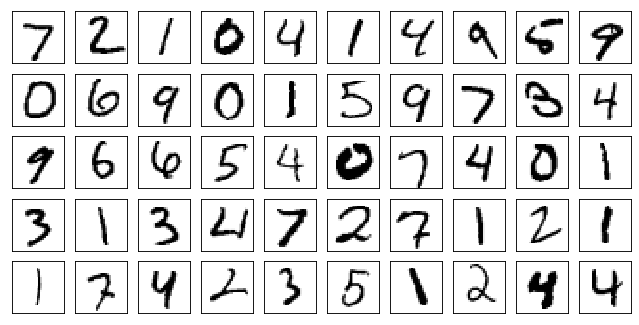

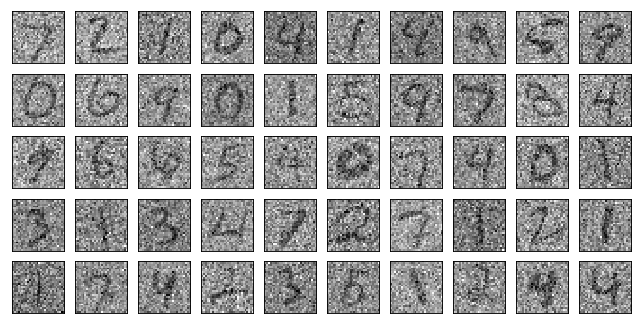

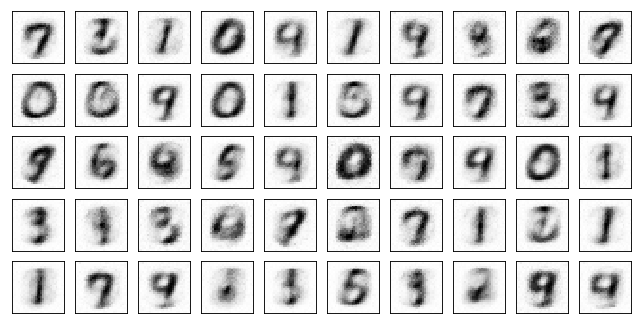

In [0]:
plot_mnist(data.data.numpy()[:50], (5, 10))
plot_mnist(noized[:50], (5, 10))
plot_mnist(to_plot, (5, 10))

##### б. Сделать отражение части изображения

In [0]:
models_mirror = {'32': Net(32)}
train_log = {k: [] for k in models_mirror}
test_log = {k: [] for k in models_mirror}

In [0]:
noise_mode = 'mirror'
for epoch in range(1, 21):
    for model in models_mirror.values():
        model.train()
    train_with_noise(epoch, models_mirror, noise_mode, train_log)
    for model in models_mirror.values():
        model.eval()
    test_with_noise(models_mirror, test_loader, noise_mode, test_log)

Train Epoch: 1 [00000/60000] 32: 0.986267
Train Epoch: 1 [30000/60000] 32: 0.616125
Train Epoch: 1 [60000/60000] 32: 0.385612
Test set:
32: loss: 0.3858

Train Epoch: 2 [00000/60000] 32: 0.378470
Train Epoch: 2 [30000/60000] 32: 0.310819
Train Epoch: 2 [60000/60000] 32: 0.288252
Test set:
32: loss: 0.2897

Train Epoch: 3 [00000/60000] 32: 0.293071
Train Epoch: 3 [30000/60000] 32: 0.284851
Train Epoch: 3 [60000/60000] 32: 0.276686
Test set:
32: loss: 0.2724

Train Epoch: 4 [00000/60000] 32: 0.272849
Train Epoch: 4 [30000/60000] 32: 0.266517
Train Epoch: 4 [60000/60000] 32: 0.262463
Test set:
32: loss: 0.2592

Train Epoch: 5 [00000/60000] 32: 0.249725
Train Epoch: 5 [30000/60000] 32: 0.262034
Train Epoch: 5 [60000/60000] 32: 0.246833
Test set:
32: loss: 0.2467

Train Epoch: 6 [00000/60000] 32: 0.245215
Train Epoch: 6 [30000/60000] 32: 0.236179
Train Epoch: 6 [60000/60000] 32: 0.237390
Test set:
32: loss: 0.2345

Train Epoch: 7 [00000/60000] 32: 0.229867
Train Epoch: 7 [30000/60000] 32: 0

In [0]:
data, _ = next(iter(test_loader))
noized = add_noise(data, 'mirror', elementwise=True)
output = models_mirror['32'](noized[:50])
to_plot = output.view(-1, 1, 28, 28).data.numpy()

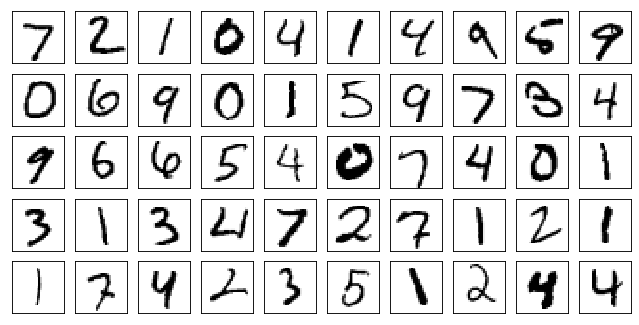

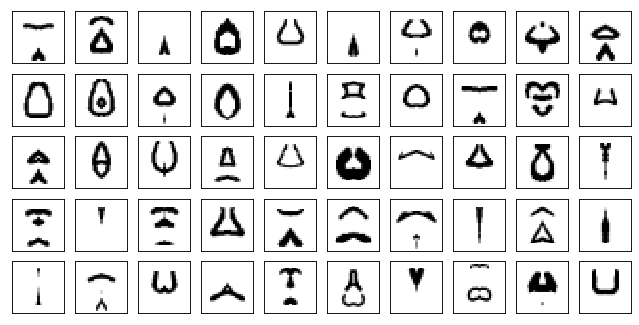

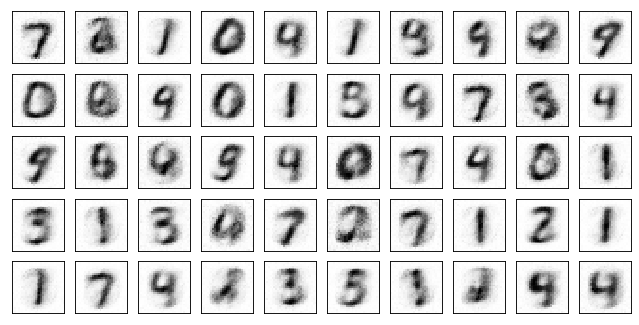

In [0]:
plot_mnist(data.data.numpy()[:50], (5, 10))
plot_mnist(noized[:50], (5, 10))
plot_mnist(to_plot, (5, 10))

##### в. Отрисовать карты активаций нейронов первого слоя

In [0]:
# модель, обученная на данных с нормальным шумом
E_fc1_weights_g = [p for p in models_gaussian['32'].E.fc1.parameters()][0]

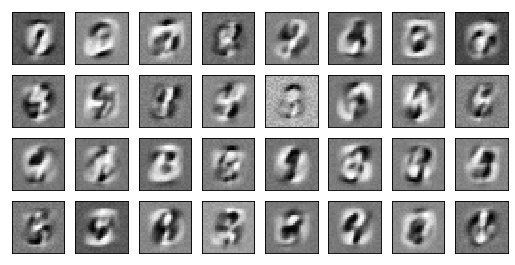

In [0]:
plot_mnist(E_fc1_weights_g.view(-1, 1, 28, 28).data.numpy(), (4, 8))

In [0]:
# модель, обученная на данных с нормальным шумом
E_fc1_weights_m = [p for p in models_mirror['32'].E.fc1.parameters()][0]

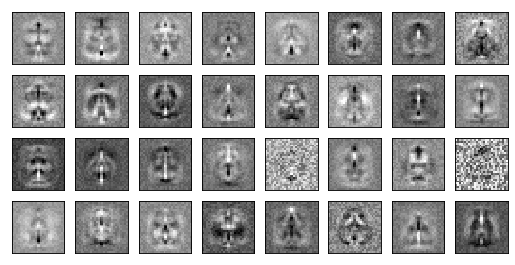

In [0]:
plot_mnist(E_fc1_weights_m.view(-1, 1, 28, 28).data.numpy(), (4, 8))

##### г.Дополнительное задание. Найти для одного нейрона латентного слоя изображение, максимизирующее его активацию

In [0]:
# достанем веса первого нейрона модели, обученной на данных с нормальным шумом
neuron_weights = E_fc1_weights_g[0]
print(neuron_weights.shape)

torch.Size([784])


In [0]:
# нам нужно добиться максимальной активации нейрона со слоя энкодера
# активация этого слоя - сигмоид. максимальное значение сигмоида = 1
# возьмём полносвязную сеть с одним нейроном в одном скрытом слое 
layer = nn.Linear(784, 1, bias=False)
layer_opt = optim.Adam(params=list(layer.parameters()))

In [0]:
# зададим лосс-функцию сигмоидом, умноженным на -1.
# обучим данную сеть, подавая как обучающий датасет одну "картинку" - веса одного нейрона исходной сети 
x = neuron_weights
log_freq = 500
for i in range(10000):
    if i%log_freq == 0:
        with torch.no_grad():
            out = torch.sigmoid(layer(x))
            loss = -torch.sigmoid(out)
        print('Ошибка после %d итераций: %f' %(i/log_freq, loss))
    layer_opt.zero_grad()
    out = torch.sigmoid(layer(x))
    loss = -torch.sigmoid(out)
    loss.backward()
    layer_opt.step()

Ошибка после 0 итераций: -0.624679
Ошибка после 1 итераций: -0.730567
Ошибка после 2 итераций: -0.730894
Ошибка после 3 итераций: -0.730976
Ошибка после 4 итераций: -0.731009
Ошибка после 5 итераций: -0.731027
Ошибка после 6 итераций: -0.731037
Ошибка после 7 итераций: -0.731043
Ошибка после 8 итераций: -0.731047
Ошибка после 9 итераций: -0.731050
Ошибка после 10 итераций: -0.731052
Ошибка после 11 итераций: -0.731054
Ошибка после 12 итераций: -0.731055
Ошибка после 13 итераций: -0.731056
Ошибка после 14 итераций: -0.731056
Ошибка после 15 итераций: -0.731057
Ошибка после 16 итераций: -0.731057
Ошибка после 17 итераций: -0.731058
Ошибка после 18 итераций: -0.731058
Ошибка после 19 итераций: -0.731058


In [0]:
# веса полученного слоя представляют собой набор данных, максимизирующий активацию нужного нейрона
layer_weights = [p for p in layer.parameters()][0] 

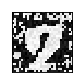

In [0]:
plot_mnist(layer_weights.view(-1, 1, 28, 28).data.numpy(), (1, 1))